# Informe nº3
    Notas: breve actualización del TFG. Introducción a la estimación de la radaón difusa.
    Fecha: 24/05/2020

   ### Referenciado de las posiciones cardinales en las imágenes cielo        
    Se muestran los puntos cardinales, a modo de refenrecia, en una imágen todo-cielo.
   
   ### Propuesta de dos métodos para determinación del ángulo sólido
    Se exponen dos métodos para determinar el ángulo sólido, debido a que el ángulo sólido queda definido por una superficie y una distancia, resulta difícil determinar el ángulo sólido, ya que las nubes, tanto entre sí, como con el sol, se encuentran a diferentes distancias de la cámara.

   ### Introducción de un nuevo parámetro para la estimación de la porción del sol cubierto
    Se propone la introducción de un parámetro para definir los momentos en los que el sol se encuentra cubierto total o parcialmente por nubes.

   ### Estimación de la radiación difusa
   
   + #### Definición de los parámetros de la estimación
   + #### Primeros resulatdos utilizando un método de regresión lineal
   
### Propuesta de algoritmo a utilizar para la estimación de radiación difusa


In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install pvlib
!pip install pyephem
!pip install pandas
!pip install datetime

import cv2
import numpy as np
import pandas as pd
import datetime as dt
import math
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pvlib as pv
from datetime import datetime as dt
from glob import glob

from mascaras import *
from funciones_algoritmo import *
from muestra_imagenes import *

### Referenciado de las posiciones cardinales en las imágenes cielo  
     Mediante los métodos de calibrado expresados en el informe anterior se muestran a continuación los puntos cardinales en una de las imágenes obtenidas por la cámara.

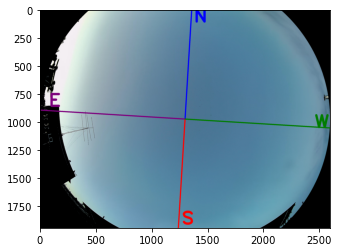

In [2]:
# Se lee una de las imaganes, como ejemplo, leemos la imagen patron
path_fotos_patron = 'Fotos Cielo/Patron/'
img_patron = cv2.imread(path_fotos_patron + 'imagen_patron.jpg', cv2.IMREAD_COLOR)

# Se realiza el pre-procesdo de la imagen
img_patron_proc = pre_procesado(img_patron)

# Se dibujan los puntos cardinales
img_patron_pnts = puntos_cardinales(img_patron_proc)

# Se muestra la imagen con los puntos cardinales
muestra_imagen(img_patron_pnts)

### Propuesta de dos métodos para determinación del ángulo sólido
    Se proponen a continucación dos formas de expresar el ángulo sólido. En un caso representamos un pseudo-ángulo sólido con forma circular, y en el otro caso determinamos el ángulo sólido por medio de las coordenadas de la imagen(azimuth y zenith).

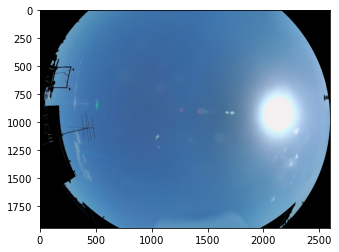

In [3]:
# Inicialmente, se dectecta la posición del sol. En el caso en el que no se pueda detectar, se obtiene el centroide teórico
# Eliminación de falsas nubes en el disco solar
path_fotos = 'Fotos Cielo/'
images = glob(path_fotos + '*.jpg')

# Tomamos un imagen como ejemplo, en la que claramente no hay nubes y el sol está totalmente despejado
ruta_imagen = images[0]
img_bgr = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
hora_img = hora_imagen(ruta_imagen)
img_proc = pre_procesado(img_bgr)


# Obtenemos el centroide a partir del resultados de la deteccion del sol
res_sol = sol_cubierto(img_proc, hora_img)
centroide = res_sol[1]

muestra_imagen(img_proc)

In [4]:
# Se define la matriz cuyos valores indican el ángulo zenital y azimutal de cada píxel
pixel_pos = lambda pos: (pixel_zenith(pos), pixel_azimuth(pos))
# pixels_pos = np.fromfunction(np.vectorize(pixel_pos), (X,Y), dtype=int)
pixels_pos = np.array([[pixel_pos([x,y]) for y in range(Y)] for x in range(X)])

pixels_zeniths = pixels_pos[:,:,0]
pixels_azimuths = pixels_pos[:,:,1]

C:\Users\nitra\Documents\GitHub\Camara\funciones_algoritmo.py:230: RuntimeWarning: divide by zero encountered in long_scalars
  alpha = np.rad2deg(np.arctan(delta_x / delta_y))
C:\Users\nitra\Documents\GitHub\Camara\funciones_algoritmo.py:230: RuntimeWarning: invalid value encountered in long_scalars
  alpha = np.rad2deg(np.arctan(delta_x / delta_y))


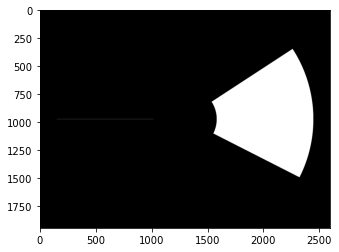

In [5]:
# Se definen las máscaras que cubren un ángulo zenital entre 10 y 30 grados, 
# y un ángulo azimutal entre 180 y 220 grados
zenith, azimuth = pos_solar(hora_img)
azimuth += f_error_azimuth()(azimuth)

delta = 30
mask_Z = cv2.inRange(pixels_zeniths, zenith - delta, zenith + delta)
mask_A = cv2.inRange(pixels_azimuths, azimuth - delta, azimuth + delta)
mask_ang_sol = cv2.bitwise_and(mask_Z, mask_A)

plt.figure(1)
muestra_imagen(mask_ang_sol)

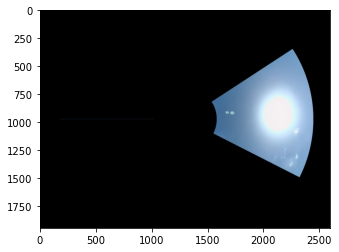

In [6]:
# Se muestra la imagen, aplicando el ángulo sólido
img_ang_sol1 = cv2.bitwise_and(img_proc,img_proc, mask=mask_ang_sol)
muestra_imagen(img_ang_sol1)

Este método es muy costoso desde el punto de vista del tiempo de procesamiento, ya que calcula el zenith y el azimuth de cada pixel. Puede ser un método válido para la obtenciñón del ángulo sólido deseado, pero hay que tener en cuenta el tiempo de procesamiento que conlleva.

In [7]:
# Con ángulo solido circular...
# Matriz cuyo valor es las distancias a un punto concreto
f_pixel_dist = lambda y,x: pixel_dist([y,x], centroide)
# pixels_dist = np.fromfunction(np.vectorize(f_pixel_dist), (X,Y), dtype=int)
pixels_dist = np.array([[f_pixel_dist(y,x) for y in range(Y)] for x in range(X)])

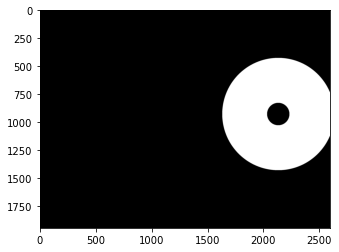

In [8]:
# Pseudo-ángulo sólido, desde una distancia de 50 pixs hasta 200 pix del centroide solar
mask_dist = cv2.inRange(pixels_dist, 100, 500)

plt.figure(1)
muestra_imagen(mask_dist)

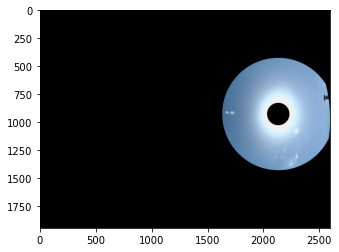

In [9]:
# Se muestra la imagen, aplicando el ángulo sólido circular
img_ang_sol2 = cv2.bitwise_and(img_proc,img_proc, mask=mask_dist)
muestra_imagen(img_ang_sol2)

Por otro lado, este método es más rápido, pero no representa un ángulo sólido real, ya que la forma de la zona destacada se mantiene circular. Puede llegar a ser válido en momentos en los que se necesita una estimación rápida.

### Introducción de un nuevo parámetro para la estimación de la porción del sol cubierto
    Se define el parámetro factor_solar como indicativo de la situación en la que se encutran el sol. Un valor alto de este factor indica que es sol está despejado, llegando la máximia radiación directa posible. Valores medios indican que el sol se encuentra tapado por nubes poco densas y, valores bajos indican que el sol se encuentra tapado por nubes muy densas, llegando gran parte de su radiación de forma difusa.
    Este factor se define mediante la circularidad y el área de del disco solar, en función del rango en el que se encuentren estos los parámetros se puede predecir la situación en la que se encuentra el sol. Se ha observado que valores altos de circularidad son presentes cuando el disco solar está libre de nubes, por otro lado, se ha observado el área del disco solar en imágenes del cielo despejado con el fin de obtener un rango de áreas válido para el disco solar.

El valor de este factor se encuentra en un rango de [0,1], pudiendo tener los siguientes valores:
+ valor 1: circularidad alta y área del disco solar similar al sol despejado.
+ valor 0.85: circularidad alta y área similar, aunque en menor medida, al sol despejado
+ valor 0.75: circularidad media y área similar al sol desjepado
+ valor 0.25: circualridad media y área fuera de rango
+ valor 0.0: circularidad baja, independientemente del área

Para el cálculo del rango de áreas en los que se puede encontrar el disco solar cuando en el no se encuentren nubes, se ha propuesto la obtención de una función en la que se relaciona el área del sol con la distancia a la que se encuentra del centro de la imágen. Se cree que es un método válido debido a la distorsión que presentan las lentes estilo ojo de pez, con gran ángulo de visión, haciendo que los objetos aumenten su tamaño a medida que se alejan del centro de la imágen. Debido a la relación expuesta el informe anterior, entre el zenith y la distancia a la que se encuentra del centro de la imagen se ha utilizado este parámetro. En vez de utilizar el ángulo zenital, se ha utilizado el ratio Zenith/90°.

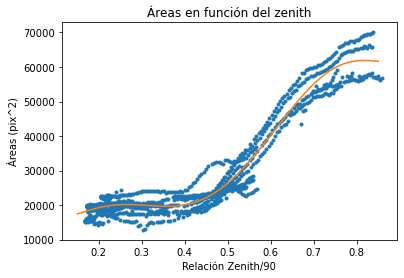

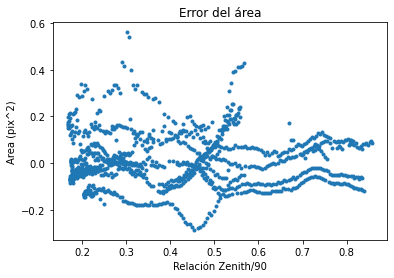

In [10]:
# Observación del área en función del zenith de la imágen
areas = pd.read_csv('Datos/datos_areas.csv')

# Se eliminan los valores que presentan una circualridad baja(por su posibilidad de contener nubes
# poco visibles en la imágen) en el disco solar
areas = areas[areas['Circul'] > 0.5]

# Predicción del modelo en función del zenith
x_zenith = areas['Zenith']
y_areas = areas['Area']
z_areas = np.polyfit(x_zenith, y_areas, 6)
p_areas = np.poly1d(z_areas)
xp_zenith = np.linspace(0.15, 0.85, 912)

fig, ax = plt.subplots()
ax.plot(x_zenith, y_areas, '.', xp_zenith, p_areas(xp_zenith), '-')
ax.set(xlabel='Relación Zenith/90', ylabel='Áreas (pix^2)',
       title='Áreas en función del zenith')

plt.show()

# Se muestra el error relativo
areas['A_Z'] = p_areas(areas['Zenith'])

x_zenith = areas['Zenith']
y_e_area = (areas['A_Z'] - areas['Area']) / areas['Area']

fig, ax = plt.subplots()
ax.plot(x_zenith, y_e_area, '.')
ax.set(xlabel='Relación Zenith/90', ylabel='Area (pix^2)',
       title='Error del área')

plt.show()

Como se observa, el error realtivo se encuentra en un rango de +-20% en un amplio porcentaje de las medidas tomadas, por lo que tomaremos este rango para determinar el factor solar.

### Añadida funcionalidad a la detección de nubes
    Como se vión en el informe anterior, un error muy grave de los métodos de detección de nubes es la correcta identificación de estas en momentos en los que el sol está descubierto. Como se observó, estos método daban falsos positivos, en algunos casos alterando muy gravemente la máscara de nubes y, por tanto, falseando las medidas calculadas de la porción de cielo cubierto por nubes. A continuación, se propone un método mediante el cual se elimina este error con el uso del factor solar:

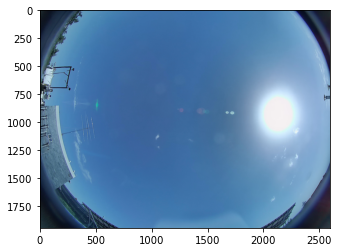

In [11]:
# Eliminación de falsas nubes en el disco solar
path_fotos = 'Fotos Cielo/'
images = glob(path_fotos + '*.jpg')

# Tomamos un imagen como ejemplo, en la que claramente no hay nubes y el sol está totalmente despejado
img_bgr = cv2.imread(images[0], cv2.IMREAD_COLOR)
ruta_imagen = images[0]
muestra_imagen(img_bgr)

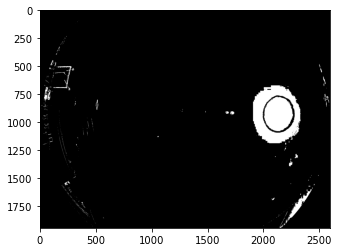

In [12]:
# Se detectan las nubes, con el error comentado anteriormente
img_proc = pre_procesado(img_bgr)
mask_nubes = mascara_nubes(img_proc)

muestra_imagen(mask_nubes)

Como se observa en la imagen, hay un falso positivo, causado por el efecto del sol saturando los pixeles a su alrededor, a continuación se elinian estos pixeles, sólo en el caso de que el factor solar sea 1, es decir, el sol se encuentre totalmente descubierto.

La imagen tiene un factor solar de: 1.00


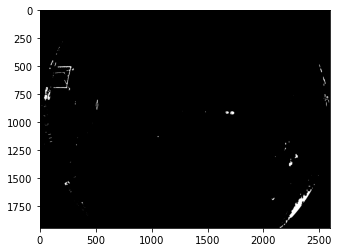

In [13]:
# Se calcula el facto solar...
res_sol = sol_cubierto(img_proc, hora_imagen(ruta_imagen))
factor_solar = res_sol[0]
print('La imagen tiene un factor solar de: {:.2f}'.format(factor_solar))

# Se eliminan las nubes...
centroide = res_sol[1]
mask_nubes = mascara_nubes(img_proc, centroide)

muestra_imagen(mask_nubes)

Como se ve en la imagen, se ha eliminado la zona en la que se había comentido un falso positivo. Se puede observar que hay zonas en las que se han detectado nubes a pesar de que no las hay, como en la parte izq de la imagen, esto no es relevante ya que en el computo de la porción de cielo cubierto por nubes, este pequeño error es práctimente irrelevante.

### Definición de los parámetros necesarios para la estimación de la radiación difusa
    En la bibliografía se encuentra la documentación que se ha consultado para determinar los parámetros que afetan a la cantidad de radiación difusa medida. Como hemos podido ver en informes anteriores, se ha estimado la porción de cielo que se encuentra cubierta por nubes, este factor es uno de los que se utilizará para la estimación de la radiacion difusa. Por otro lado, la posición del sol, determinada por el momento del día, será un factor determinante de la cantidad de radiacion que se mide como difusa. Además, la intensidad media de los pixels tanto de cielo, como de las nubes, puede ser un parámetro que nos ayude a estimar esta radiación. Por último, se propone añadir la radiación extra-atmosférica como un factor más, debido a que esta es dependiente de la hora del día en la que nos encontremos, por otro lado, es una porción de esta la que finalmente llega a la superficie de la tierra como la componente de radiación difusa.

A continuación, se prone un método de regresión lineal multivariable, mediante el cual se hace una primera estimación de la radiación difusa por medio de los parámetros comentados anteriormente:

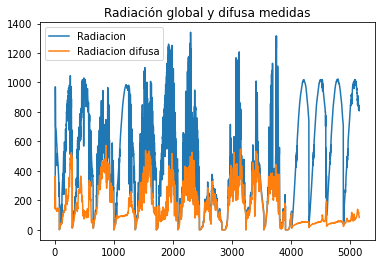

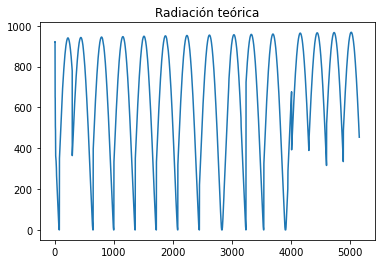

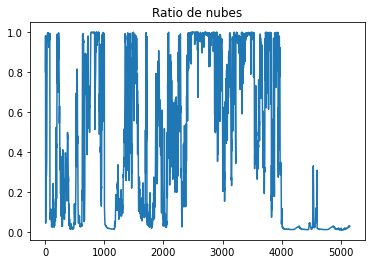

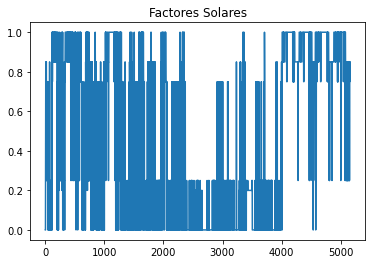

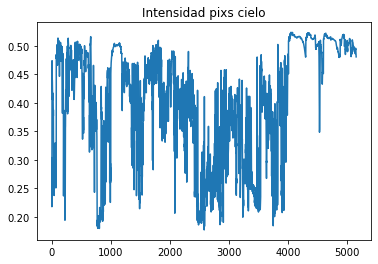

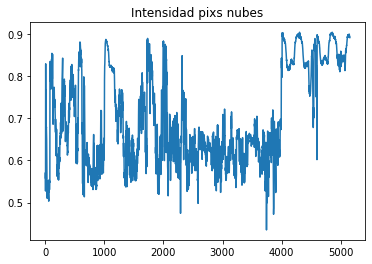

In [14]:
# Lectura del dataframe con los valores obtenidos, formado por todos los parámetros indicados anteriormente
# junto con los datos de las radiaciones global y difusa medidas en las estaciones
pd_info_regresion = pd.read_csv('Datos/info_regresion.csv')

plt.figure(1)
pd_info_regresion['Radiacion'].plot(title='Radiación global y difusa medidas', legend=True)
pd_info_regresion['Radiacion difusa'].plot(legend=True)
plt.figure(2)
pd_info_regresion['ghi'].plot(title='Radiación teórica', legend=False)
plt.figure(3)
pd_info_regresion['Ratio nubes'].plot(title='Ratio de nubes', legend=False)
plt.figure(4)
pd_info_regresion['Factor solar'].plot(title='Factores Solares', legend=False)
plt.figure(5)
pd_info_regresion['Intensidad cielo'].plot(title='Intensidad pixs cielo', legend=False)
plt.figure(6)
pd_info_regresion['Intensidad nubes'].plot(title='Intensidad pixs nubes', legend=False)

Cómo se puede observar a continuación, para realizar el modelo de regresión lineal se ha realizado ligeras modificaciones a las medidas obtenidas:
+ En vez de introducir el factor solar, se introduce la medida (1 - factor solar), ya que cuando más tapado se encuentra el sol, menos componente directa se mide, y por tanto, mayor radiación difusa obtenemos.
+ Debido a que la radiacon disponible a lo largo del día no es constante, se ha multilicado las intensidades medias y el factor solar por la radiación téorica extra-atmosférica, ya que esta medida es depentiente del tiempo.
+ Por último, el peso de cada intensidad media esta relacionada con la porción de cielo que presenta esta intensidad. Por ejemplo, si el cielo está totalmente libre de nubes, no es lógico que la intensidad media de las nubes tenga el mismo peso que la intensidad media del cielo. Por ello, se ha multipicado cada intensidad media por la porción del cielo que le corresponde.

In [15]:
# Predicción del modelo
from sklearn import linear_model

regr = linear_model.LinearRegression()

pd_info_regresion['Factor solar'] = 1 - pd_info_regresion['Factor solar']
for column in pd_info_regresion.columns:
    if column in ['Intensidad cielo', 'Intensidad nubes', 'Factor solar']:
        pd_info_regresion[column] *= pd_info_regresion['ghi']
        
pd_info_regresion['Intensidad nubes'] *= pd_info_regresion['Ratio nubes']
pd_info_regresion['Intensidad cielo'] *= 1 - pd_info_regresion['Ratio nubes']


y_rad = pd_info_regresion['Radiacion difusa']
x_rad = pd_info_regresion[['ghi', 'Ratio nubes', 'Factor solar', 'Intensidad cielo', 'Intensidad nubes']]

regr.fit(x_rad, y_rad)
print('El corficiente de regresión es: {:.2f}'.format(regr.score(x_rad, y_rad)))

El corficiente de regresión es: 0.38


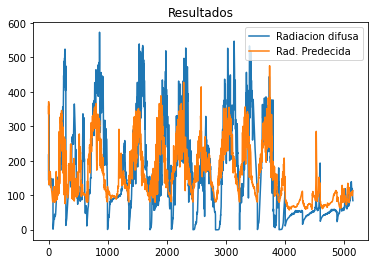

In [16]:
# Predicción de la radiación difusa
predicted_rad = []
for i in range(len(pd_info_regresion)):
    predicted_rad.append(regr.predict([pd_info_regresion[['ghi', 'Ratio nubes', 'Factor solar','Intensidad cielo', 'Intensidad nubes']].iloc[i].to_list()])[0])

pd_predicted = pd_info_regresion
pd_predicted['Rad. Predecida'] = predicted_rad

# Se imprimen los resutados
pd_predicted['Radiacion difusa'].plot(title='Resultados', legend=True)
pd_predicted['Rad. Predecida'].plot(legend=True)

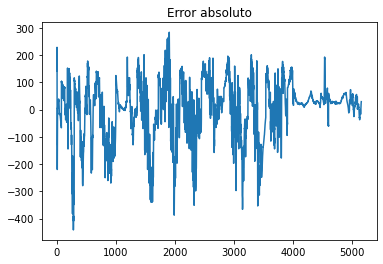

In [17]:
# Errores obtenidos: Radiación predecida - Radiación difusa medida
errores = pd_predicted['Rad. Predecida'] - pd_predicted['Radiacion difusa']
errores.plot(title='Error absoluto', legend=False)

Como podemos observar los resultados del modelo obtenido no son ideales, pero presentan una forma similar a la radiación difusa medida en las estaciones. Es un método lejano a ser adecuado para la estimación, pero como primera toma de contacto es adecuado. Nos muestra que los parámetros que hemos elegido son adecuados para la estimación, y que se puede llegar a realizar un estimación mejor de la radiación. Como conclusión, podemos ver que el coeficiente de regresión(R^2) se encuentra en torno a 0.4, valor muy bajo para considerar este método válido, con lo que se continuará con la búsqueda de un método más adecuado.

### Propuesta de algoritmo a utilizar para la estimación de radiación difusa
    Con la obtención de un primer método para la estimación de la radiación difusa, surge la necesidad de explicar el procedimiento completo para la obtención de un valor de esta radiación. Desde la lectura de la imagen pasando por el procesamiento de la misma, hasta la estimación del valor.
    Para ello utilizaremos las funciones definidas en el script pertinete:

La hora de la imagen es 2020-05-04 17:33:00.
La imagen tiene un factor solar de 1.00.
El ratio nubes-cielo es de 0.56%.
Las intensidad media del cielo es de 0.51 tanto por uno.
Las intensidad media de las nubes es de 0.56 tanto por uno.
La radiación extra-atmosférica es de 649.41 W/m2.
La radiación difusa que obtenemos es de 80.41 W/m2.
La radiación difusa medida es de 293.53 W/m2.


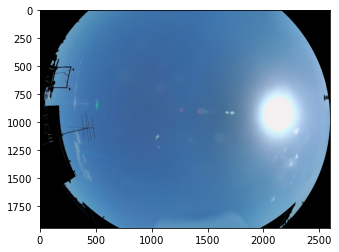

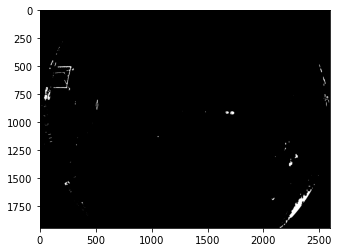

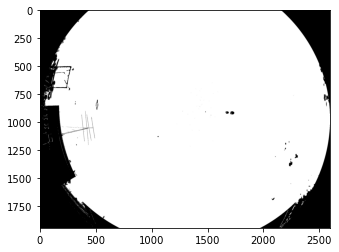

In [18]:
# Tomamos una imagen como ejemplo...
# Paso 1: Lectura de la imagen:
ruta_imagen = images[0]
img_bgr = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)

# Paso 2: Pre-procesamiento de la imagen y obtención de la hora de la imagen
img_proc = pre_procesado(img_bgr)
plt.figure(1)
muestra_imagen(img_proc)
hora_img = hora_imagen(ruta_imagen)
print('La hora de la imagen es {}.'.format(hora_img))

# Paso 3: Determinación del factor solar y detección del sol:
res_solar = sol_cubierto(img_proc, hora_img)

# Paso 3.1: Si el resultado es un float, el factor solar es 0, sol no detectado
if res_solar == 0:
    factor_solar = 0
    # Se obtiene el centroide teórico, ya que el real no se ha podido detectar...
    centroide = centroide_solar(hora_img, imagen=True)
    
# Paso 3.2: Si el resultado es distinto de 0, entonces se devuelve una lista con...
else:
    factor_solar = res_solar[0]
    centroide = res_solar[1]

print('La imagen tiene un factor solar de {:.2f}.'.format(factor_solar))
# Paso 4: si el factor solar es 1, se elimina el error en la máscara de nubes...
if factor_solar == 1:
    cnt_img = centroide
else: # ... y sino la mascara es la original
    cnt_img = None

mask_nubes = mascara_nubes(img_proc, cnt_img)
plt.figure(2)
muestra_imagen(mask_nubes)

# Paso 5: Cálculo del porcentaje de cielo cubierto por nubes
ratio_nubes = porcion_nubes_cielo(mask_nubes)
print('El ratio nubes-cielo es de {:.2f}%.'.format(ratio_nubes*100))

# Paso 6: Cáñculo de las intensidades medias del cielo y de las nubes:
mask_cielo = cv2.bitwise_not(mask_nubes, mask=cielo)
plt.figure(3)
muestra_imagen(mask_cielo)

intensidad_cielo = intensidad_media(img_proc, mask=mask_cielo)
intensidad_nubes = intensidad_media(img_proc, mask=mask_nubes)

print('Las intensidad media del cielo es de {:.2f} tanto por uno.'.format(intensidad_cielo/255))
print('Las intensidad media de las nubes es de {:.2f} tanto por uno.'.format(intensidad_nubes/255))

# Paso 7: Obtención de la radiación teórica extra-atmosférica:
ghi = rad_extra_atmosferica(hora_img)
print('La radiación extra-atmosférica es de {:.2f} W/m2.'.format(ghi))

# Paso 8: Finalmente, con las medidas obtenidas anteriormente, se obtiene la radiación difusa:
params = [ghi, ratio_nubes, factor_solar, intensidad_cielo , intensidad_nubes]
rad_difusa_estim = rad_difusa(params) 
    
print('La radiación difusa que obtenemos es de {:.2f} W/m2.'.format(rad_difusa_estim))
print('La radiación difusa medida es de {:.2f} W/m2.'.format(pd_info_regresion.set_index('Unnamed: 0').loc[hora_img.strftime('%Y-%m-%d %H:%M:%S'), 'Radiacion']))

# Comentarios 
+ Para la estimación de la radiación difusa se han utlizado todas las imágenes disponibles, incluyendo días soleados, nublados, lluviosos, etc.
+ El algortimo expuesto se encuentra a modo de ejemplo, no es el definitivo. Debido a que se ha expuesto un método de estimación de la radiación difusa, se ha visto oportuno exponer el procedieminto a seguir una vez obtniedo el modelo final. Además, como se puede ver, el error en la radiación difusa es demasiado elevado como para considerarlo un modelo válido. 
+ En cuanto al ángulo sólido, se incluirán ambos métodos en la librería, existiendo la posibilidad de seleccionar cuál de los dos métodos utilizar.

## Trabajos en proceso
+ Como se ha comentado anteriormente en las medidas realizadas no se ha realizado ningún tipo de selección, es decir, todas las imagenes tomadas se han utilizado para la estimación. Como se observa en las gráficas de las predicciones, hay una clara diferencia entre los días nublados(% rad. difusa relativamnete alto) frente a los dias soleados(% rad. difusa bajo). Se está tabajando en una estimación por separado de ambos escenarios, tomando como referencia el ratio de nubes del cielo.
+ Se ha expuesto un método de regresión lineal en el que se han incluido todos los parámetros comentados, no se ha tenido en cuenta cuales de estos pueden ser más relevantes o cuales pueden ser inadecuados. Se está trabajando en determinar cuales de estos parámetros favorecen la estimación de la radiación y cuales son aquellos, si los hay, que simplemente están incluyendo "ruido" a las predicciones.
+ Se están buscando métodos alternativos al expuesto que puedan mejorar las estimaciones realizadas, teniendo en cuenta lo comentado anteriormente.

# Bibliografía
#### Parámetros necesarios para la estimación de la radiación difusa
    Modeling Solar Radiation at the Earth's Surface, Badescu, Viorel (Ed.), 2008   
#### Modelo para la estimación de la readiación difusa
    Predicting solar irradiance with all-sky image features via regression, Chia-Lin Fu, Hsu-YungCheng, https://doi.org/10.1016/j.solener.2013.09.016